## map2loop: From geology layers to outputs to various 3D modelling programs- Hamersley example (Geomodeller)

This notebook reads in three layers from  local or remote sources:  geology polygons, orientation data and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into geomodeller to make a 3D model 
<img src='../graphics/map_sm.png'>

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
import time
%matplotlib inline
t0 = time.time()

#newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)
print("Current Working Directory " )

gdal_data = os.environ['GDAL_DATA']
print("***",gdal_data)
print('is dir: ' + str(os.path.isdir(gdal_data)))
gcs_csv = os.path.join(gdal_data, 'gcs.csv')
print('is file: ' + str(os.path.isfile(gcs_csv)))
#st = os.stat(gcs_csv)
#print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
os.environ['PROJ_LIB']=r"C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj"
print(os.getenv('PROJ_LIB'))
print(os.getcwd())

Current Working Directory 
*** C:\Program Files\PostgreSQL\11\gdal-data
is dir: True
is file: True
C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


## Create bounding box based on inputs

In [2]:
test_data_name='nishka'

test_data_path='../'+test_data_name+'/'
print(test_data_path)
os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "m2l_config_remote.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


../nishka/
Default parameters loaded from ../nishka/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=704151  #region of interest coordinates in metre-based system (or non-degree system)
maxx=807779
miny=7394169
maxy=7466677
model_top=5000
model_base=-10000


#PATHS

local_paths=True       #flag to use local or WFS source for data inputs (True = local)

test_data_path='../nishka/'

geology_file='Hammersley_merge_plus.shp'   #input geology file (if local)
fault_file='Faults.shp' #input fault file (if local)
structure_file='Bedding_data.shp' #input bedding orientation file (if local)
mindep_file='mindeps_2018.shp' #input mineral deposit file (if local)

#CRS

src_crs = {'init': 'EPSG:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'EPSG:28350'} # coordinate system for data

#CODES AND LABELS 
# these refer to specific fields (codes) in GIS laye

In [3]:

fold_decimate=2         

contact_decimate=5

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

pluton_form='domes'

fault_dip=90

min_fault_length=5000

compute_etc=False

#local_paths=False
#################################
# There are many alternative datasets that can be extracted from the input data, 
# and many choices of possible input data
#
# These flags define what the actual workflow will be for this experiment
#################################
workflow={'seismic_section':False,
          'map':True,
          'cover_map':False,
          'near_fault_interpolations':True,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':False,
          'get_remote_dtm':False,
          'fault_offset':False}

# no cover info so no need load cover layers
cover_map=False
dtb=0
dtb_null=0

## First we test to see if we have access to the online data we need


In [4]:
loopwfs=m2l_utils.have_access("geo.loop-gis.org")
hawaii=m2l_utils.have_access("pae-paha.pacioos.hawaii.edu")

if(not (loopwfs & hawaii)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True

available: geo.loop-gis.org
available: pae-paha.pacioos.hawaii.edu


## Optional WFS source
  
WFS brings in field names as lower case, so need to redefine codes too

In [5]:
if((not local_paths) and net):
    structure_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=warox_points_f5011&bbox='+bbox2+'&srs=EPSG:28350'
    fault_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=linear_500k&bbox='+bbox2+'&srs=EPSG:28350'
    geology_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k&bbox='+bbox2+'&srs=EPSG:28350'

    c_l= {
    #Orientations
      "d": "dip",                  #field that contains dip information
      "dd": "dip_dir",             #field that contains dip direction information
      "sf": 'feature',             #field that contains information on type of structure
      "bedding": 'Bed',            #text to search for in field defined by sfcode to show that this is a bedding measurement
    #Stratigraphy
      "g": 'group_',               #field that contains coarser stratigraphic coding
      "c": 'code',                 #field that contains finer stratigraphic coding
      "ds": 'descriptn',           #field that contains information about lithology
      "u": 'unitname',             #field that contains alternate stratigraphic coding (not used??)
      "r1": 'rocktype1',           #field that contains  extra lithology information
      "r2": 'rocktype2',           #field that contains even more lithology information
      "sill": 'sill',              #text to search for in field defined by dscode to show that this is a sill
      "intrusive": 'intrusive',    #text to search for in field defined by dscode to show that this is an intrusion
      "volcanic": 'volcanic',      #text to search for in field defined by dscode to show that this is an intrusion
    #Mineral Deposits
      "msc": 'SITE_CODE',          #field that contains site code of deposit
      "msn": 'SHORT_NAME',         #field that contains short name of deposit
      "mst": 'SITE_TYPE_',         #field that contains site type of deposit
      "mtc": 'TARGET_COM',         #field that contains target commodity of deposit
      "mscm": 'SITE_COMMO',        #field that contains site commodity of deposit
      "mcom": 'COMMODITY_',        #field that contains commodity group of deposit
      "minf": 'Infrastructure',    #text to search for in field defined by mst code that shows site to ignore
    #Timing
      "min": 'min_age_ma',         #field that contains minimum age of unit defined by ccode
      "max": 'max_age_ma',         #field that contains maximum age of unit defined by ccode
    #faults and folds
      "f": 'feature',              #field that contains information on type of structure
      "fault": 'Fault',            #text to search for in field defined by fcode to show that this is a fault
      "fold": 'Fold axial trace',  #text to search for in field defined by fcode to show that this is a fold axial trace
      "n": 'name',                 #field that contains information on name of fault (not used??)
      "t": 'type',                 #field that contains information on type of fold
      "syn": 'syncline',           #text to search for in field defined by t to show that this is a syncline
    #ids
      "o": 'objectid',             #field that contains unique id of geometry object
      "gi": 'geopnt_id'            #field that contains unique id of structure point
    }

## Plot geology polygons and bounding box

../nishka/data/Hammersley_merge_plus.shp


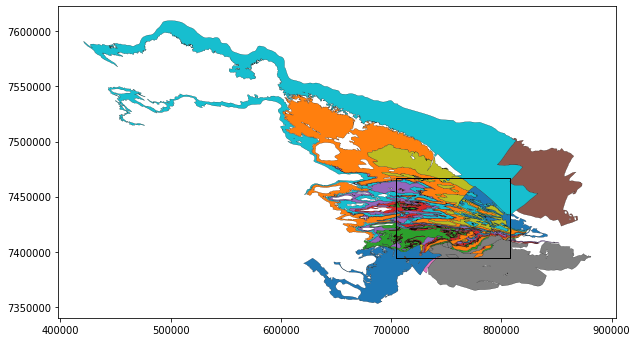

In [6]:
print(geology_file)
geology_ll = gpd.read_file(geology_file,bbox=bbox)

base=geology_ll.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


## Save geology to file as WKT

In [7]:
hint_flag=True # use GSWA strat database to provide relative age hints
sub_geol = geology_ll[['geometry', c_l['o'],c_l['c'],c_l['g'],c_l['u'],c_l['min'],c_l['max'],c_l['ds'],c_l['r1'],c_l['r2']]]
m2l_topology.save_geol_wkt(sub_geol,geology_file_csv, c_l,hint_flag)

Using ENS age hints
274  polygons


## Save mineral deposits to file as WKT
This is not needed by map2loop to build 3D models, but is used by map2model to calculate mineral deposit/topology analyses.

214  points


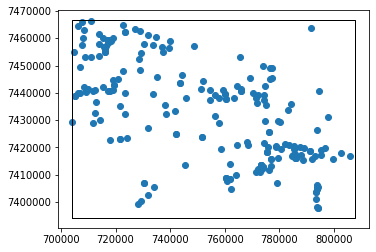

In [8]:
mindep = gpd.read_file(mindep_file,bbox=bbox)

sub_mindep = mindep[['geometry', c_l['msc'],c_l['msn'],c_l['mst'],c_l['mtc'],c_l['mscm'],c_l['mcom']]]
m2l_topology.save_mindep_wkt(sub_mindep,mindep_file_csv, c_l)

base=sub_mindep.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Read and save WAROX point data as WKT

619  points


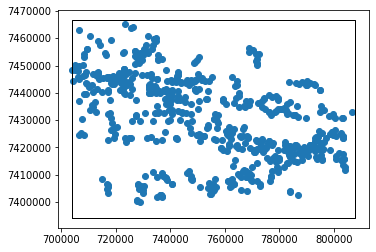

In [9]:
warox = gpd.read_file(structure_file,bbox=bbox)

sub_pts = warox[['geometry', c_l['gi'],c_l['d'],c_l['dd']]]

m2l_topology.save_structure_wkt(sub_pts,structure_file_csv,c_l)

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

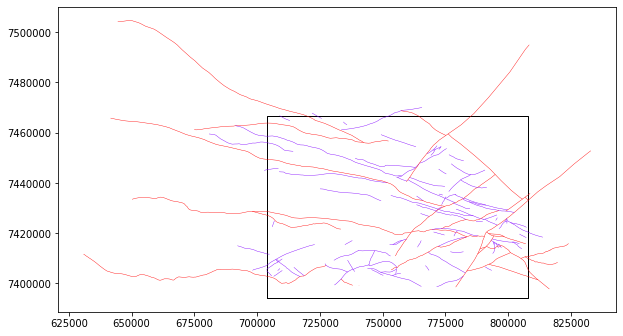

In [10]:
lines_ll=gpd.read_file(fault_file,bbox=bbox)

base2=lines_ll.plot(cmap='rainbow',column=c_l['f'],figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [11]:
sub_lines = lines_ll[['geometry', c_l['o'],c_l['f']]]
m2l_topology.save_faults_wkt(sub_lines,fault_file_csv,c_l)

134  polylines


## Create map2model input file

In [12]:
m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,structure_file_csv,mindep_file_csv,minx,maxx,miny,maxy,500.0,'Fe,Cu,Au,NONE')


## Calculate topology

In [13]:
import subprocess
import platform
os.chdir(m2m_cpp_path)
print(os.getcwd())
#%system map2model.exe Parfile
if(platform.system()=='Windows'):
    subprocess.run(["map2model.exe", "Parfile"], capture_output=True)
else:
    subprocess.run(["./map2model", "Parfile"], capture_output=True)

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\m2m_cpp


## Simple network graph of the geology with legend

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


0    'Weeli Wolli Formation'
1    'Pinjian Chert Breccia'
2    'Sylvania Inlier greenstones'
3    'Fortescue Group'
4    'Brockman Iron Formation'
5    'Mount McRae Shale and Mount Sylvia Formation'
6    'Jeerinah Formation'
7    'Bunjinah Formation'
8    'Marra Mamba Iron Formation'
9    'Wittenoom Formation'
10    'Bresnahan Group'
11    'Sylvania Inlier granitic unit'
12    'Pyradie Formation'
13    'Proterozoic mafic intrusive unit'
14    'Hardey Formation'
15    'Boolgeeda Iron Formation'
16    'Woongarra Rhyolite'
17    'Turee Creek Group'


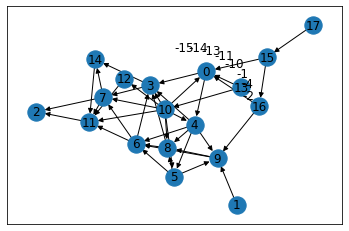

In [14]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## Detailed Topology via dot or gml format files
For a more detailed look we can open up the online version of <b>yEd</b> <a href="https://www.yworks.com/yed-live/" >https://www.yworks.com/yed-live/</a>  and load in the *.dot file that we will now create or dowload the <a href="https://www.yworks.com/products/yed/download">yEd program</a> and look at the *.gml files in the <b>output</b> directory

from networkx.drawing.nx_pydot import write_dot

import filer,gfiler

filepath=filer.gui_fname().decode('UTF-8')
write_dot(G,filepath)

http://localhost:8888/notebooks/Dropbox/1_Jupyter_notebooks/map2loop/notebooks/2.%20map2loop_after_topology.ipynb

## Process topography, stratigraphy, fold axial traces and faults

### Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>

<font color='red'>Currently mostly hardwired to GSWA 500K map so needs work...</font>


In [15]:
os.chdir('../map2loop')

print(os.getcwd())

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


In [16]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

sys.path.insert(0,"../..")
print(os.getcwd())


#print(os.getcwd())
#os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Next we define an area of interest and some other basic stuff

In [17]:
print(os.getcwd())
#test_data_path='../test_data3/'


#%run -i "../test_data3/m2l_config.py"

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


#contact_decimate=5

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Download and reproject the appropriate SRTM data
mj: Getting this from GA, but could also get from Hawaii

In [18]:
polygon_ll=polygon.to_crs(src_crs)

minlong=polygon_ll.total_bounds[0]-step_out
maxlong=polygon_ll.total_bounds[2]+step_out
minlat=polygon_ll.total_bounds[1]-step_out
maxlat=polygon_ll.total_bounds[3]+step_out

local_paths=False
print(minlong,maxlong,minlat,maxlat)
if(((not os.path.exists(dtm_file)) or (not local_paths)) and net):     
    m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat)
    geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)



118.94526490120109 120.05929268543932 -23.595002207762704 -22.834573105288715
dtm geotif saved as ../nishka/dtm/dtm.tif
reprojected dtm geotif saved as ../nishka/dtm/dtm_rp.tif


In [19]:
print(os.path.exists(dtm_file))

True


## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.

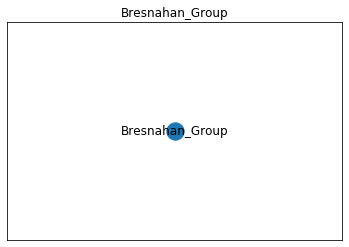

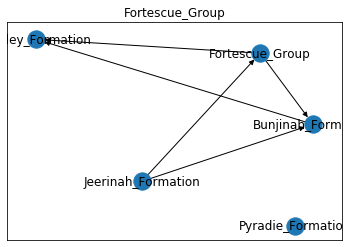

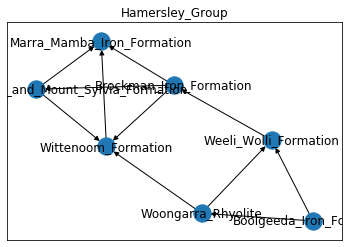

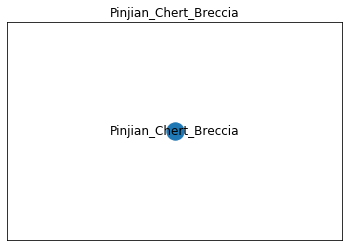

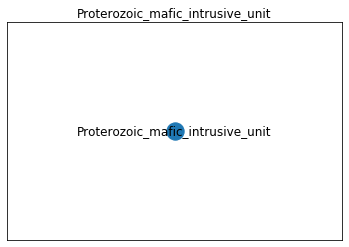

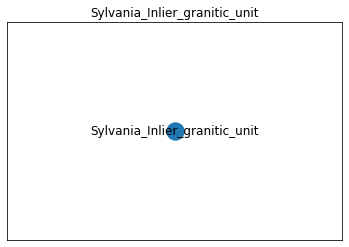

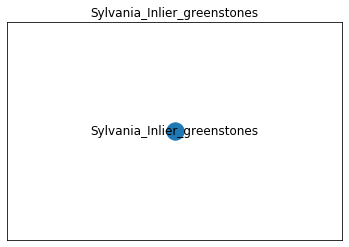

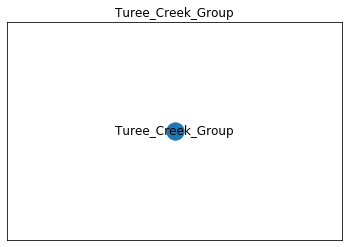

In [20]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
m2l_topology.save_units(G,tmp_path,glabels)

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

../nishka/data/Faults.shp


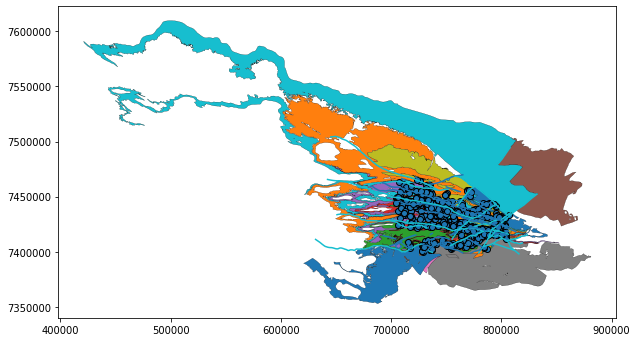

In [21]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
faults = gpd.read_file(fault_file,bbox=bbox)
faults.crs=dst_crs
#display(faults)
sub_pts = structure[['geometry',c_l['d'],c_l['dd'],c_l['sf']]] 

base=geology.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base,edgecolor='black')
faults.plot(ax=base, column=c_l['f'],edgecolor='black')

## Clip geology, faults, structures and map geology to structures

geometry  DIP  STRIKE  \
0     POINT (775100.006447552 7419750.135380931)   65     106   
1     POINT (739495.2250347659 7439681.95502731)   48      76   
2    POINT (779479.6987295841 7437258.912353164)   39     101   
3    POINT (748163.5578113433 7429628.001175508)   30      87   
4    POINT (742564.4911768166 7437311.192211218)   54     265   
5    POINT (782064.1616903468 7421972.012799576)   48     285   
6    POINT (777532.1145331728 7438559.815881459)   61     267   
7    POINT (733433.2648092823 7456176.921787644)   29     276   
8    POINT (768292.5326125122 7424287.988709524)   62     308   
9    POINT (766194.7100779358 7404542.265921929)   59      99   
10   POINT (794984.3826622665 7440922.856510563)   76     120   
11    POINT (746343.1145854755 7428965.78381166)   21      88   
12   POINT (762239.0138052686 7423208.353227241)   30      72   
13    POINT (774959.783506982 7434125.711420907)   40     291   
14    POINT (747761.227690099 7436094.458646597)   43     254   
15   POINT (725800.3788774272 7423627.735788656)   58     115   
16    POINT (747985.358578435 7444223.519640315)   35     119   
17   POINT (716897.4324007261 7404954.492089894)   52      76   
18   POINT (760598.9783604142 7426002.080024786)   74     280   
19   POINT (799693.2645230943 7425843.627736302)   68     220   
20    POINT (749123.557133951 7441419.053051131)   33     293   
21   POINT (738535.7493269028 7448266.051120295)   69     277   
22   POINT (732225.0775284423 7441301.356597442)   52      79   
23   POINT (754057.7167159969 7427451.866182143)   48     109   
24    POINT (764292.3279304515 7438115.38235684)   48     108   
25   POINT (787157.3996288157 7443404.013252946)   21     122   
26   POINT (788388.2664652397 7444065.286012403)   39     254   
27    POINT (798508.2263000014 7425081.60404163)   25      56   
28   POINT (742766.0794103412 7440570.882264532)   65     110   
29   POINT (778063.4249718242 7416214.697232295)   54     285   
30   POINT (719344.6408917194 7427225.380098755)   27     298   
31   POINT (755984.0526984088 7430559.104413265)   23     122   
32   POINT (720614.2342118967 7445996.086587988)   65     265   
33   POINT (717788.8301654237 7437374.628955241)   63      93   
34    POINT (762750.0679510954 7445692.30901441)   37      95   
35   POINT (793290.7960835595 7422530.989840041)   18     300   
36   POINT (722109.9118475245 7447120.539870795)   39     284   
37   POINT (734828.1036367294 7439883.526904988)   52      83   
38   POINT (742225.5292634745 7423557.838992003)   49     107   
39   POINT (738339.4821228652 7408807.320918386)   90      71   
40   POINT (774232.5803004773 7419781.751059078)   47     125   
41    POINT (734394.316213675 7432760.950970644)   26     108   
42   POINT (795544.8449071008 7435110.257658796)   34     275   
43   POINT (754754.3055411133 7402975.307793331)   55      98   
44   POINT (785440.3363198361 7419718.329303626)   50      93   
45   POINT (768921.1390237343 7456438.307173025)   16      51   
46   POINT (717405.5626217731 7406140.116420971)   39     290   
47   POINT (802860.4736402899 7415537.656407591)   73     287   
48     POINT (752695.341861628 7444396.20033421)   54     108   
49     POINT (737675.3729294781 7440835.5943943)   52      93   
50   POINT (766739.9063396233 7411214.897015368)   21     200   
51   POINT (796380.9786185734 7433660.431385113)   21     314   
52    POINT (770707.9743325042 7419199.44053418)   29      98   
53   POINT (729539.9049883167 7452167.750605052)   90     111   
54   POINT (761368.4847087029 7407864.713537343)   37      60   
55   POINT (787409.0040560589 7418088.591656473)   42     116   
56   POINT (738096.1396201298 7409251.123574136)   64     263   
57   POINT (734764.8181446311 7440941.464903758)   55      82   
58   POINT (778402.2515743985 7416871.081384672)   45     123   
59   POINT (734700.9845235629 7441248.250033709)   78     104   
60   POINT (765424.0933815688 7434686.588491827)   55     129   
61   POINT

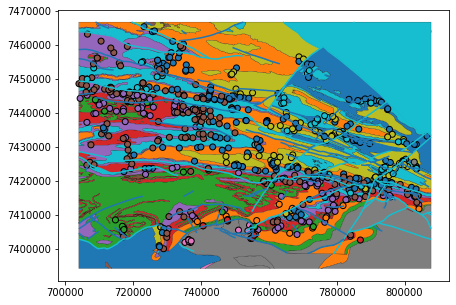

In [22]:
geology = m2l_utils.explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geology, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
#display(polygo.geometry)
is_bed=structure_code[c_l['sf']].str.contains(c_l['bedding'], regex=False) 
    
all_beds = structure_code[is_bed]
#display(sfcode)
#all_folds=faults[faults[c_l['f']].str.contains(c_l['fold'])]
#folds_clip=m2l_utils.clip_shp(all_folds,polygo)
#folds_clip.to_file(tmp_path+'folds_clip.shp')


all_faults=faults[faults[c_l['f']].str.contains(c_l['fault'])]



#display(structure_code)
#geol_clip=m2l_utils.clip_shp(geology, polygo)
geol_clip=gpd.overlay(geology, polygo, how='intersection')
faults_clip=m2l_utils.clip_shp(all_faults,polygo)
#display(faults_clip)
structure_clip = m2l_utils.clip_shp(all_beds, polygo)
#structure_clip=gpd.overlay(all_beds, polygo, how='intersection')
display(structure_clip)
base = geol_clip.plot(column=c_l['c'],figsize=(7,7),edgecolor='#000000',linewidth=0.2)
faults_clip.plot(ax=base, column=c_l['f'],edgecolor='black')
structure_clip.plot(ax=base, column=c_l['c'],edgecolor='black')


#if(c_l['dd']=='strike'):
#    structure_clip['azimuth2'] = structure_clip.apply(lambda row: row[c_l['dd']]+90.0, axis = 1)
#    c_l['dd']='azimuth2'
    
    
geol_clip.to_file(tmp_path+'geol_clip.shp')
faults_clip.to_file(tmp_path+'faults_clip.shp')
structure_clip.to_file(tmp_path+'structure_clip.shp')


## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

index     min     max     ave
group_                                                         
Proterozoic_mafic_intrusive_unit      0   541.0  2500.0  1520.5
Bresnahan_Group                       1  1610.0  1786.0  1698.0
Pinjian_Chert_Breccia                 2  1317.0  2630.0  1973.5
Turee_Creek_Group                     3  2208.0  2445.0  2326.5
Hamersley_Group                       4  2445.0  2629.0  2537.0
Fortescue_Group                       5  2629.0  2775.0  2702.0
Sylvania_Inlier_granitic_unit         6  2918.0  3239.0  3078.5
Sylvania_Inlier_greenstones           7  3239.0  3530.0  3384.5

[]

group choices: 12


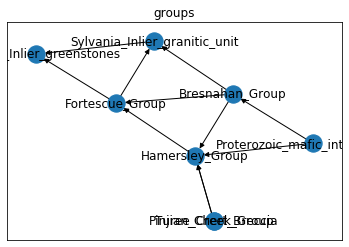

In [23]:
m2l_topology.save_group(G,tmp_path,glabels,geol_clip,c_l)

## Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up?



Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

In [24]:
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.save_orientations(structure_clip,output_path,c_l,orientation_decimate,dtm,dtb,dtb_null,cover_map)


603 orientations saved to ../nishka/output/orientations.csv


##  Display stereonets of bedding by formations and group to see how we can combine them later

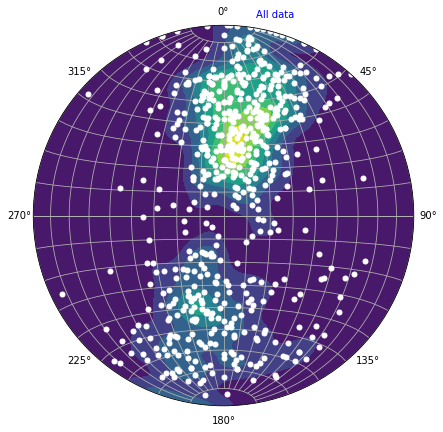

----------------------------------------------------------------------------------------------------------------------
Turee_Creek_Group observations n= 2


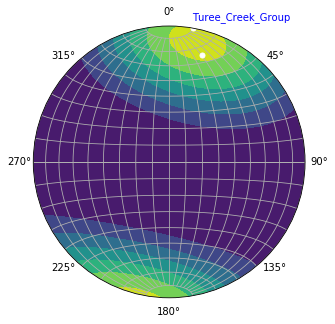

----------------------------------------------------------------------------------------------------------------------
Hamersley_Group observations n= 472


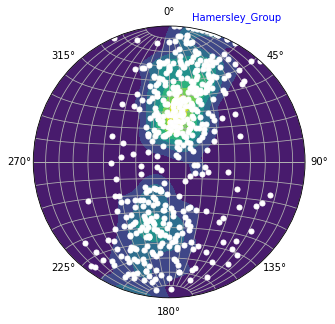

----------------------------------------------------------------------------------------------------------------------
Fortescue_Group observations n= 118


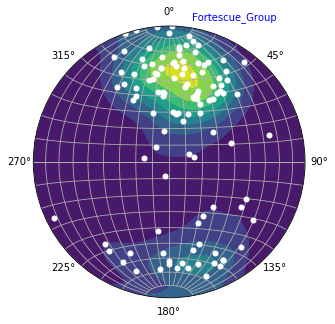

----------------------------------------------------------------------------------------------------------------------
Sylvania_Inlier_greenstones observations n= 11


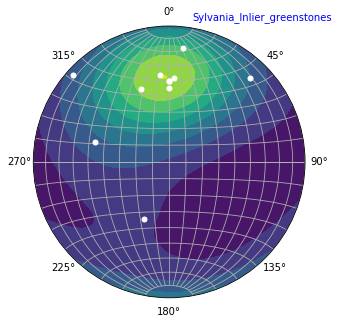

----------------------------------------------------------------------------------------------------------------------
Turee_Creek_Group
Turee_Creek_Group observations n= 2
strike/dip of girdle 10.0 / 70.50938351783188


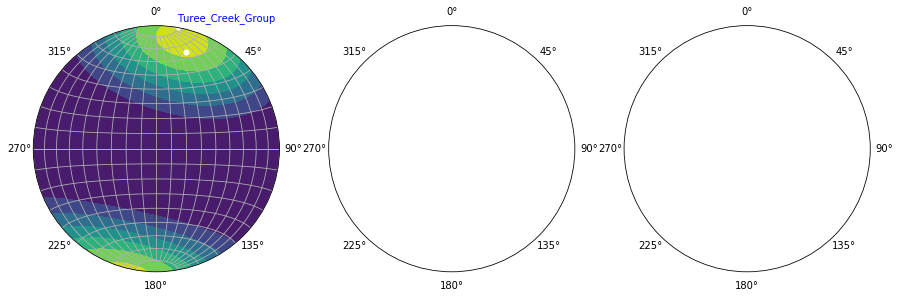

----------------------------------------------------------------------------------------------------------------------
Proterozoic_mafic_intrusive_unit
Proterozoic_mafic_intrusive_unit observations n= 0
----------------------------------------------------------------------------------------------------------------------
Bresnahan_Group
Bresnahan_Group observations n= 0
----------------------------------------------------------------------------------------------------------------------
Pinjian_Chert_Breccia
Pinjian_Chert_Breccia observations n= 0
----------------------------------------------------------------------------------------------------------------------
Hamersley_Group
Boolgeeda_Iron_Formation observations n= 31
strike/dip of girdle 9.009140552383428 / 85.20611416180857
Woongarra_Rhyolite observations n= 33
strike/dip of girdle 199.32956965998636 / 89.28110847593555
Weeli_Wolli_Formation observations n= 63
strike/dip of girdle 193.79530971242218 / 88.8561297768051


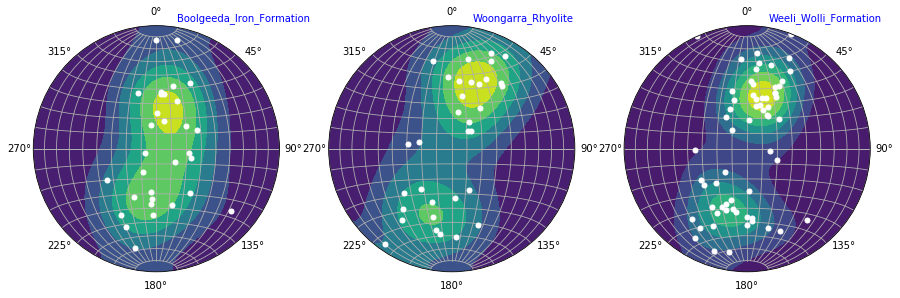

Brockman_Iron_Formation observations n= 156
strike/dip of girdle 13.767057431705553 / 88.7766856306009
Mount_McRae_Shale_and_Mount_Sylvia_Formation observations n= 55
strike/dip of girdle 193.08988104912453 / 82.91665447839694
Wittenoom_Formation observations n= 18
strike/dip of girdle 7.90576706356768 / 88.97905162081375


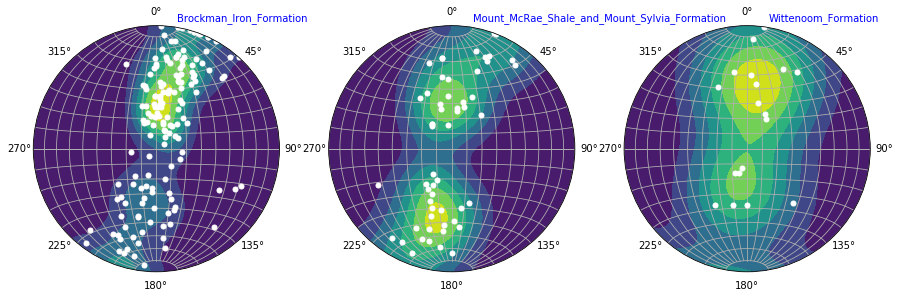

Marra_Mamba_Iron_Formation observations n= 116
strike/dip of girdle 1.6179891819921863 / 83.97243635585819


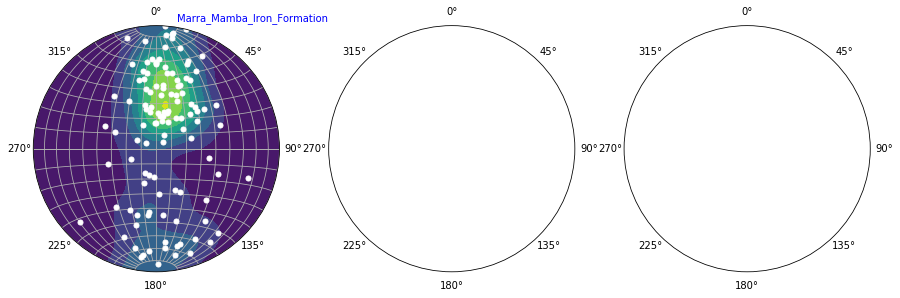

----------------------------------------------------------------------------------------------------------------------
Fortescue_Group
Pyradie_Formation observations n= 0
Jeerinah_Formation observations n= 97
strike/dip of girdle 357.0503459885691 / 74.72626918182397
Fortescue_Group observations n= 0
Bunjinah_Formation observations n= 11
strike/dip of girdle 342.68718624392045 / 56.219579533994164
Hardey_Formation observations n= 10
strike/dip of girdle 339.9405715180024 / 51.69413645006451


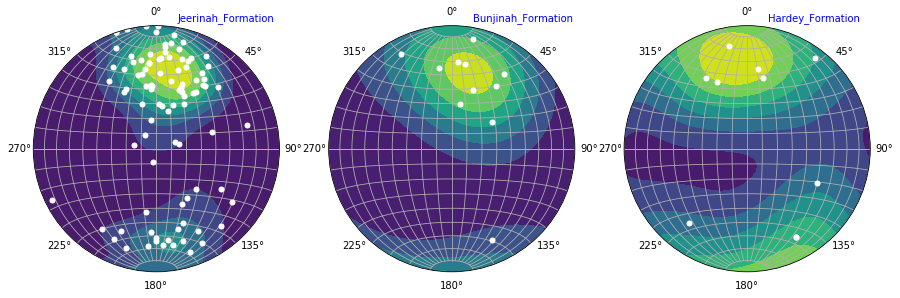

----------------------------------------------------------------------------------------------------------------------
Sylvania_Inlier_granitic_unit
Sylvania_Inlier_granitic_unit observations n= 0
----------------------------------------------------------------------------------------------------------------------
Sylvania_Inlier_greenstones
Sylvania_Inlier_greenstones observations n= 11
strike/dip of girdle 212.95075615999008 / 49.940082692581385


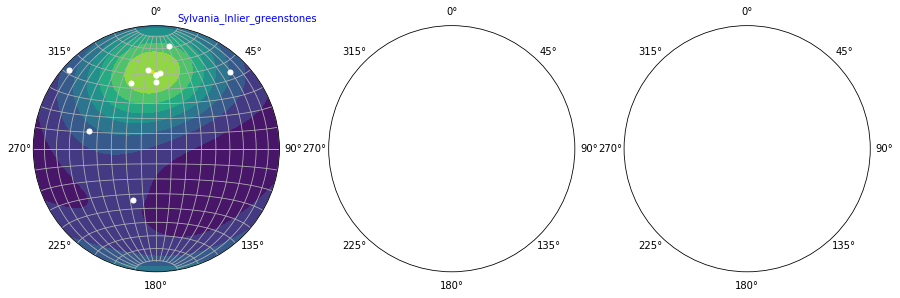

In [25]:
orientations=pd.read_csv(output_path+'orientations.csv',",")
all_sorts=pd.read_csv(tmp_path+'all_sorts.csv',",")
            
m2l_utils.plot_bedding_stereonets(orientations,all_sorts)


## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

In [26]:
m2l_geometry.create_orientations( tmp_path, output_path, dtm,dtb,dtb_null,cover_map,geol_clip,structure_clip,c_l)

extra orientations saved as ../nishka/output//empty_series_orientations.csv


## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.


<img src='../graphics/base.png'>

In [27]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(tmp_path,dtm,dtb,dtb_null,cover_map,geol_clip,contact_decimate,c_l,intrusion_mode)

basal contacts saved allpts= 15427 deci_pts= 3650
saved as ../nishka/tmp/all_contacts.csv and ../nishka/tmp/contacts.csv


## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [28]:
display(ls_dict)

{0: {'id': 0,
  'UNITNAME': 'Weeli_Wolli_Formation',
  'GROUP_': 'Hamersley_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x2c2f5b8f978>},
 1: {'id': 1,
  'UNITNAME': 'Weeli_Wolli_Formation',
  'GROUP_': 'Hamersley_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x2c2f5b8fba8>},
 2: {'id': 2,
  'UNITNAME': 'Weeli_Wolli_Formation',
  'GROUP_': 'Hamersley_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x2c2f5b8fc50>},
 3: {'id': 3,
  'UNITNAME': 'Brockman_Iron_Formation',
  'GROUP_': 'Hamersley_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x2c2f6425a58>},
 4: {'id': 4,
  'UNITNAME': 'Brockman_Iron_Formation',
  'GROUP_': 'Hamersley_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x2c2f6425ba8>},
 5: {'id': 5,
  'UNITNAME': 'Mount_McRae_Shale_and_Mount_Sylvia_Formation',
  'GROUP_': 'Hamersley_Group',
  'geometry': <shapely.geometry.multilinestring.M

In [29]:
m2l_geometry.save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

basal contacts without faults saved as ../nishka/tmp/basal_contacts.shp


## Remove faults from decimated basal contacts as save as csv file

In [30]:
contacts=gpd.read_file(tmp_path+'basal_contacts.shp')

m2l_geometry.save_basal_contacts_csv(contacts,output_path,dtm,dtb,dtb_null,cover_map,contact_decimate,c_l)

#m2l_geometry.save_contacts_with_faults_removed(tmp_path+'faults_clip.shp',output_path,10,ls_dict,ls_dict_decimate,c_l,dst_crs,dtm)

decimated contacts saved as ../nishka/output/contacts4.csv


## Process fault geometry
Save Faults as decimated points and representative orientation  
Then, for each  fault string:
- incementally advance along polyline every at each inter-node (no point in doing more?)
- find local stratigraphy 10m to left and right of fault
  
Once full fault has been traversed:
- Find list of contacts left 
- Find equivalent contacts on right
- use interpolated orientations to estimate minimum true offset assuming vertical displacement and store 
- if no equivalent found, flag as domain fault and find min strat offset for contact, use cumulative minimum thickness estimate and store with flag (not implemented)
- estimate median & sd of minimum fault offset and store with flag (not implemented)

Local Orientations
Since much of the code is the same, we benefit by calculating local orientation data either side of fault so that geomodeller/gempy have satisfied fault compartment orientation data## Save fault as contact info and and orientation info make vertical (for the moment)

In [31]:
m2l_geometry.save_faults(tmp_path+'faults_clip.shp',output_path,dtm,dtb,dtb_null,cover_map,c_l,fault_decimate,min_fault_length,fault_dip)

use_gcode=('Hamersley Group','Fortescue Group','Wyloo Group','Shingle Creek Group','Turee Creek Group' ) 
use_gcode2=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group' ) 

m2l_interpolation.process_fault_throw_and_near_orientations(tmp_path,output_path,dtm_reproj_file,dtb,dtb_null,cover_map,c_l,use_gcode,use_gcode2,dst_crs,bbox,scheme)

fault orientations saved as ../nishka/output/fault_orientations.csv
fault positions saved as ../nishka/output/faults.csv
fault dimensions saved as ../nishka/output/fault_dimensions.csv


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=1.13283e-69): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


orientations interpolated as dip dip direction ../nishka/tmp/f_interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../nishka/tmp/f_interpolation_l.csv etc.
orientations interpolated as dip dip direction ../nishka/tmp/ex_f_interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../nishka/tmp/ex_f_interpolation_l.csv etc.


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=1.82589e-29): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=1.82591e-29): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


contacts interpolated as strike ../nishka/tmp/f_interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../nishka/tmp/f_interpolation_contacts_l.csv etc.


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=1.8248e-28): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


contacts interpolated as strike ../nishka/tmp/ex_f_interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../nishka/tmp/ex_f_interpolation_contacts_l.csv etc.
{'init': 'EPSG:28350'} None
contacts and orientations interpolated as dip dip direction ../nishka/tmp/f_combo_full.csv
{'init': 'EPSG:28350'} None
contacts and orientations interpolated as dip dip direction ../nishka/tmp/ex_f_combo_full.csv


## Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with four possible sub-surface configurations:

<b>saucers: \\_+++_/ <br>
batholiths: +++/__ __ _\\+++  <br> 
domes: /‾+++‾\\ <br>
pendants: +++\\_  _/+++ <br>
</b>
  
Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>


In [32]:
from shapely.geometry import shape, Polygon, LineString, Point
from math import acos, sqrt, cos, sin, degrees, radians, fabs, atan2

bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,dtb,dtb_null,cover_map,pluton_form,pluton_dip,contact_decimate,c_l)



0 Turee_Creek_Group
1 Proterozoic_mafic_intrusive_unit
2 Bresnahan_Group
3 Pinjian_Chert_Breccia
4 Hamersley_Group
5 Fortescue_Group
6 Sylvania_Inlier_granitic_unit
7 Sylvania_Inlier_greenstones
pluton contacts and orientations saved as:
../nishka/output/ign_contacts.csv
../nishka/output/ign_orientations_domes.csv


## Extract faults and basal contacts of groups from seismic section

In [33]:
if(workflow['seismic_section']):
    seismic_line_file=data_path+'seismic_line_10GA-CP1_rev.shp'   #input geology file (if local)
    seismic_line = gpd.read_file(seismic_line_file) #import map
    seismic_line.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2) #display map
    display(seismic_line)


    seismic_bbox_file=data_path+'seismic_bbox.shp'   #input geology file (if local)
    seismic_bbox = gpd.read_file(seismic_bbox_file) #import map
    seismic_bbox.set_index('POSITION',inplace=True)

    seismic_interp_file=data_path+'seismic_interp.shp'   #input geology file (if local)
    seismic_interp = gpd.read_file(seismic_interp_file) #import map
    seismic_interp.plot(column='FEATURE',figsize=(10,10),edgecolor='#000000',linewidth=0.5) #display map
    display(seismic_interp)

    dtm_reproj_file=dtm_path+'dtm_rp.tif'
    dtm = rasterio.open(dtm_reproj_file)
    surface_cut=2000

    m2l_geometry.extract_section(tmp_path,output_path,seismic_line,seismic_bbox,seismic_interp,dtm,dtb,dtb_null,cover_map,surface_cut)

    contacts=pd.read_csv(output_path+'contacts4.csv',",")
    seismic_contacts=pd.read_csv(output_path+'seismic_base.csv',",")
    all_contacts=pd.concat([contacts,seismic_contacts],sort=False)
    all_contacts.to_csv (output_path+'contacts4.csv', index = None, header=True)

    faults=pd.read_csv(output_path+'faults.csv',",")
    seismic_faults=pd.read_csv(output_path+'seismic_faults.csv',",")
    all_faults=pd.concat([faults,seismic_faults],sort=False)
    all_faults.to_csv (output_path+'faults.csv', index = None, header=True)



## Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of these interpolations and associated code is to help in three cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Possibly useful for poulating parts of maps where little structural data is available

In [34]:
use_gcode=('Hamersley Group','Fortescue Group','Wyloo Group','Shingle Creek Group','Turee Creek Group' ) ################# MOVE UP   #########################
structure_file=tmp_path+'structure_clip.shp'
bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)

In [35]:
print(c_l['g'])
print(use_gcode)

GROUP_
('Hamersley Group', 'Fortescue Group', 'Wyloo Group', 'Shingle Creek Group', 'Turee Creek Group')


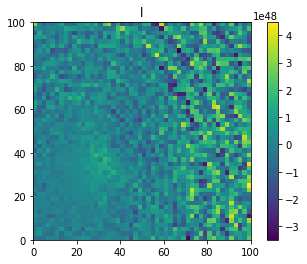

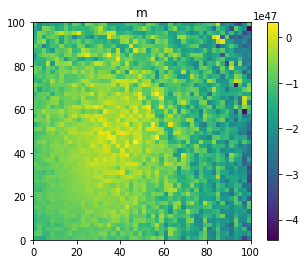

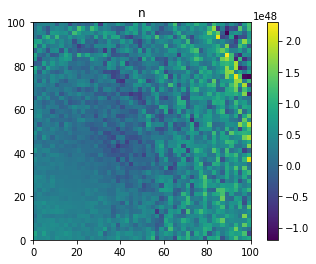

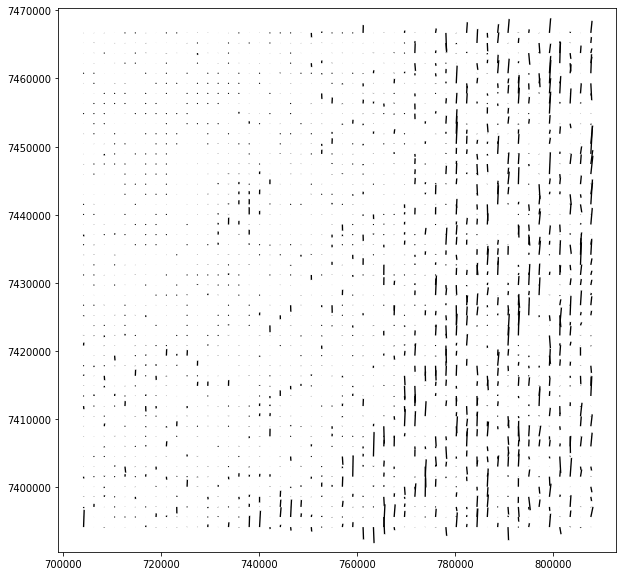

orientations interpolated as dip dip direction ../nishka/tmp/interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../nishka/tmp/interpolation_l.csv etc.


In [36]:
m2l_interpolation.interpolate_orientations(structure_file,tmp_path,bbox,c_l,use_gcode,scheme,gridx,gridy,False)

## Interpolates a regular grid from a shapefile of from contacts and saves out three csv files of l & m direction cosines and strike data

Can choose between various RBF and IDW options  

<font face color='red'>Best with basal contacts only, using Notebook #1 as this avoids intrusive  and fault contacts being considered</font>

In [37]:
geology_file=tmp_path+'basal_contacts.shp'

dtm = rasterio.open(dtm_reproj_file)
use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group' ) ################# MOVE UP   #########################


206
7138 points saved to ../nishka/tmp/raw_contacts.csv


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=8.3995e-29): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=8.39953e-29): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


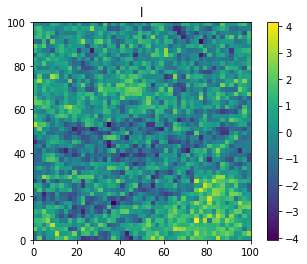

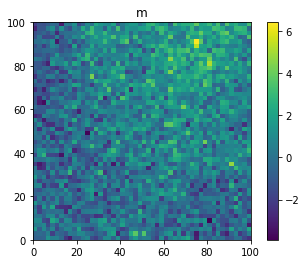

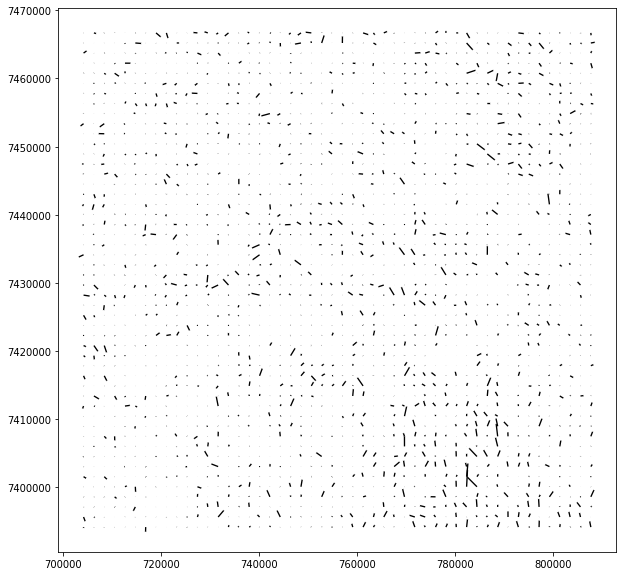

contacts interpolated as strike ../nishka/tmp/interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../nishka/tmp/interpolation_contacts_l.csv etc.


In [38]:
contact_decimate=2
null_scheme='null'

m2l_interpolation.save_contact_vectors(geology_file,tmp_path,dtm,dtb,dtb_null,cover_map,bbox,c_l,null_scheme,contact_decimate)

m2l_interpolation.interpolate_contacts(geology_file,tmp_path,dtm,dtb,dtb_null,cover_map,bbox,c_l,use_gcode,scheme,gridx,gridy,False)


## Combines rbf of contact orientations with rbf of dip/dipdir measurements

Uses normalised direction cosines **(l,m,n)**:  
- **l,m** from RBF of basal contact orientations  
- **signs of l & m** from misorientation with RBF of orientation data and  
- **n** from RBF of orientation data  
  
May be useful for adding data where no orientations are available (e.g. in fault bounded domains) and for calculating true thickness of layers. Assumes a 2D plane of data, but if 3D RBF was calulated and projected contact info was used it should apply with topography too. 

In [39]:
geology_file=tmp_path+'geol_clip.shp'
combo_file=tmp_path+'combo.csv'

lc=np.loadtxt(tmp_path+'interpolation_contacts_l.csv',skiprows =1,delimiter =',',dtype=float)
mc=np.loadtxt(tmp_path+'interpolation_contacts_m.csv',skiprows =1,delimiter =',',dtype=float)
lo=np.loadtxt(tmp_path+'interpolation_l.csv',skiprows =1,delimiter =',',dtype=float)
mo=np.loadtxt(tmp_path+'interpolation_m.csv',skiprows =1,delimiter =',',dtype=float)
no=np.loadtxt(tmp_path+'interpolation_n.csv',skiprows =1,delimiter =',',dtype=float)
xy=np.loadtxt(tmp_path+'interpolation_'+scheme+'.csv',skiprows =1,delimiter =',',dtype=float)

In [40]:
m2l_interpolation.join_contacts_and_orientations(combo_file,geology_file,tmp_path,dtm_reproj_file,dtb,dtb_null,cover_map,c_l,lo,mo,no,lc,mc,xy,dst_crs,bbox,False)


{'init': 'EPSG:28350'} None
contacts and orientations interpolated as dip dip direction ../nishka/tmp/combo_full.csv


## Propagate dips along contacts


In [41]:
contact_dip=45
contact_orientation_decimate=5
m2l_geometry.save_basal_contacts_orientations_csv(contacts,orientations,geol_clip,tmp_path,output_path,dtm,dtb,
                                         dtb_null,workflow['cover_map'],contact_orientation_decimate,c_l,contact_dip)

## Estimate formation thickness and normalised formation thickness

In [42]:
if(workflow['formation_thickness']):
    buffer =5000
    max_thickness_allowed=10000

    m2l_geometry.calc_thickness(tmp_path,output_path,buffer,max_thickness_allowed,c_l)

    m2l_geometry.normalise_thickness(output_path)

## Creates fold axial trace points

In [43]:
if(workflow['fold_axial_traces']):
    m2l_geometry.save_fold_axial_traces(tmp_path+'folds_clip.shp',output_path,dtm,dtb,dtb_null,cover_map,c_l,fold_decimate)

    #Save fold axial trace near-hinge orientations
    fat_step=750         # how much to step out normal to fold axial trace
    close_dip=20.0       #dip to assign to all new orientations

    m2l_geometry.save_fold_axial_traces_orientations(tmp_path+'folds_clip.shp',output_path,tmp_path,dtm,dtb,dtb_null,cover_map,c_l,dst_crs,fold_decimate,fat_step,close_dip,scheme)


## Preprocess data to ensure it meets modelling requirements

In [44]:
if(local_paths): ###############FUDGE#############
    use_gcode=('Hamersley_Group','Fortescue_Group','Turee_Creek_Group','A_mgn_PRK',  'A_mgn_PMI' ) ################# MOVE UP   #########################
    #use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PRK',  'A_mgn_PMI' ) ################# MOVE UP   #########################
else:
    use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PMI',  'A_mgn_PRK' ) ################# MOVE UP   #########################


print('only processing',use_gcode)

#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
inputs=('invented_orientations','intrusive_orientations','near_fault_orientations','contact_orientations')

m2l_geometry.tidy_data(output_path,tmp_path,use_gcode,use_interpolations,use_fat,pluton_form,inputs,workflow)

only processing ('Hamersley_Group', 'Fortescue_Group', 'Wyloo_Group', 'Shingle_Creek_Group', 'Turee_Creek_Group', 'A_mgn_PMI', 'A_mgn_PRK')
no orientations for the group: Bresnahan_Group
no orientations for the group: Pinjian_Chert_Breccia
no orientations for the group: Proterozoic_mafic_intrusive_unit
no orientations for the group: Sylvania_Inlier_greenstones
no orientations for the group: Sylvania_Inlier_granitic_unit


## 6c Calculate minimum fault offset from stratigraphy and stratigraphic fault offset

In [45]:
if(workflow['fault_offset']):
    m2l_geometry.fault_strat_offset(output_path,c_l,dst_crs,output_path+'formation_summary_thicknesses.csv', tmp_path+'all_sorts.csv',tmp_path+'faults_clip.shp',tmp_path+'geol_clip.shp',output_path+'fault_dimensions.csv')


    m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'min_offset','X','Y',True)
    m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'strat_offset','X','Y',True)


## Analyse fault-fault topology

cycles [['Fault_57', 'Fault_475', 'Fault_85', 'Fault_365']]


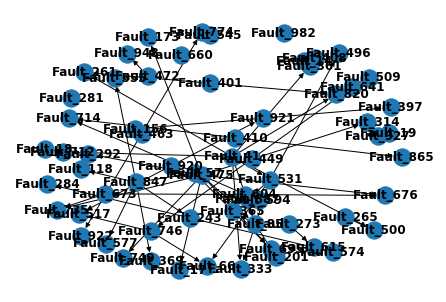

In [46]:
m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2gemodeller test 



In [47]:
save_faults=True
compute_etc=True
m2l_export.loop2geomodeller(test_data_path,tmp_path,output_path,'./dtm/dtm_rp.tif',bbox,save_faults,compute_etc,workflow)
t1 = time.time()

In [48]:
os.chdir(test_data_path)
%system geomodellerbatch.exe -batch m2l.taskfile
t2 = time.time()

In [49]:
#%system geomodellerbatch.exe -batch m2l_compute.taskfile
t3 = time.time()

In [50]:
#import winsound
#duration = 500  # milliseconds
#freq = 1100  # Hz
#winsound.Beep(freq, duration)
#winsound.Beep(freq, duration)
#duration=999
#winsound.Beep(freq, duration)


In [51]:
print("m2l",(t1-t0)/60.0,"batch process",(t2-t1)/60.0,"batch calculate",(t3-t2)/60.0,"minutes")

m2l 51.072135571638746 batch process 1.1861716190973917 batch calculate 0.0003886898358662923 minutes
